In [2]:
import os
import json
import pandas as pd
from datetime import datetime
from typing import List, Dict, Tuple

In [7]:
# 2. Pfade definieren (bitte anpassen)
with open('../models/config.json', 'r') as f:
    config = json.load(f)

postprocess = config['postprocessing']

IINPUT_PATH_S_OBJ = postprocess['input_path_s_obj']  # Pfad zu den Zielfunktionswerten
INPUT_PATH_HD = postprocess['input_path_hd']         # Pfad zu den Wahrscheinlichkeiten

# Liste der Daten (Daten müssen als Strings im Format 'YYYYMMDD' vorliegen)
dates = ['20230303', '20230316', '20230403', '20230409', '20230514', '20230515', '20230619', '20230622', '20230626', '20230709', '20230710']

# 3. Schleife über alle Daten
for date in dates:
    start_date = date
    end_date = date

    # Pfade zu den Dateien
    obj_values_file = os.path.join(IINPUT_PATH_S_OBJ, f's_{start_date}_to_{end_date}_day_obj.csv')
    probabilities_file = os.path.join(INPUT_PATH_HD, f'reduced_heat_demand_scenarios_{start_date}_to_{end_date}_day.json')
    
    # Überprüfen, ob die Dateien existieren
    if not os.path.exists(obj_values_file):
        print(f"Zielfunktionswerte-Datei für Datum {date} nicht gefunden: {obj_values_file}")
        continue  # Überspringt dieses Datum

    if not os.path.exists(probabilities_file):
        print(f"Wahrscheinlichkeits-Datei für Datum {date} nicht gefunden: {probabilities_file}")
        continue  # Überspringt dieses Datum

    # 3.1 Einlesen der Zielfunktionswerte
    df_obj = pd.read_csv(obj_values_file)
    # Entferne eventuelle Leerzeichen in den Spaltennamen
    df_obj.columns = df_obj.columns.str.strip()

    # Überprüfe, ob die notwendigen Spalten vorhanden sind
    if 'Scenario:' in df_obj.columns:
        df_obj.rename(columns={'Scenario:': 'Scenario'}, inplace=True)
    elif 'Scenario' not in df_obj.columns:
        print(f"Spalte 'Scenario' nicht in Zielfunktionswerte-Datei {obj_values_file} gefunden.")
        continue

    if 'ObjectiveValue' not in df_obj.columns:
        print(f"Spalte 'ObjectiveValue' nicht in Zielfunktionswerte-Datei {obj_values_file} gefunden.")
        continue

    # 3.2 Einlesen der Wahrscheinlichkeiten
    with open(probabilities_file, 'r') as f:
        probabilities_data = json.load(f)

    # Erstelle ein DataFrame für die Wahrscheinlichkeiten
    probabilities_list = []
    for scenario_name, scenario_info in probabilities_data.items():
        probability = scenario_info.get('Probability', None)
        if probability is None:
            print(f"Wahrscheinlichkeit für {scenario_name} nicht gefunden.")
            continue
        probabilities_list.append({'Scenario': scenario_name, 'Probability': probability})

    df_prob = pd.DataFrame(probabilities_list)

    # 3.3 Zusammenführen der Daten
    df_merged = pd.merge(df_obj, df_prob, on='Scenario', how='inner')

    # 3.4 Speichern der kombinierten Daten als CSV
    output_filename = f's_obj_values_{date}.csv'
    output_filepath = os.path.join('../data/postprocessing/obj/', output_filename)
    df_merged.to_csv(output_filepath, index=False)
    print(f"Kombinierte Datei für Datum {date} gespeichert: {output_filepath}")

    # Optional: Anzeige der kombinierten Daten
    print(df_merged)


Kombinierte Datei für Datum 20230303 gespeichert: ../data/postprocessing/obj/s_obj_values_20230303.csv
     Scenario  ObjectiveValue  Probability
0   Scenario1     -296.576816     0.213933
1   Scenario2     -296.502492     0.085874
2   Scenario3     -295.818144     0.060216
3   Scenario4     -295.657638     0.115567
4   Scenario5     -295.955625     0.098109
5   Scenario6     -296.765985     0.064584
6   Scenario7     -294.736693     0.078224
7   Scenario8     -296.008946     0.061210
8   Scenario9     -295.577155     0.061475
9  Scenario10     -295.881650     0.160809
Kombinierte Datei für Datum 20230316 gespeichert: ../data/postprocessing/obj/s_obj_values_20230316.csv
     Scenario  ObjectiveValue  Probability
0   Scenario1     -326.915809     0.093211
1   Scenario2     -327.040740     0.041917
2   Scenario3     -325.951884     0.073168
3   Scenario4     -327.274089     0.164225
4   Scenario5     -326.848278     0.096919
5   Scenario6     -326.980714     0.165247
6   Scenario7     -3

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
C:\Users\paul\AppData\Local\Temp\ipykernel_25212\2150091021.py:26: SyntaxWarning: invalid escape sequence '\d'
  df['ScenarioNum'] = df['Scenario'].str.extract('(\d+)').astype(int)


Gewichteter Zielfunktionswert: -296.0179


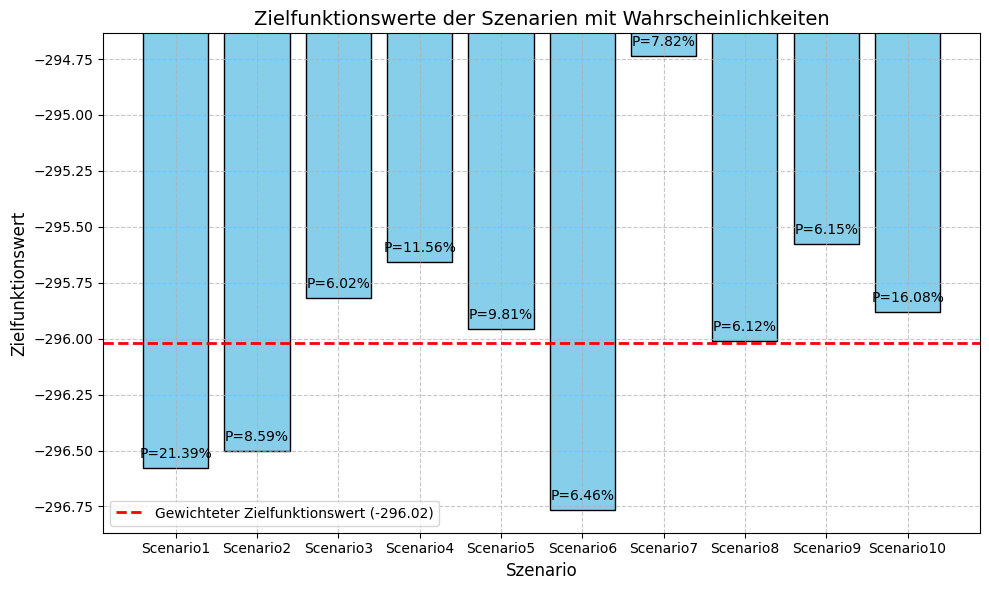

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Daten einlesen
data = {
    'Scenario': ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 
                 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10'],
    'ObjectiveValue': [-296.5768163227874, -296.50249249135004, -295.81814399728154, -295.65763779124336, 
                       -295.9556254994654, -296.76598523170753, -294.736692987626, -296.0089463175659, 
                       -295.5771554169005, -295.8816503357336],
    'Probability': [0.2139325904510971, 0.08587360637460136, 0.06021611016333947, 0.11556655713823559, 
                    0.09810850340646698, 0.0645843712152516, 0.07822426048797672, 0.06120965934401877, 
                    0.06147537050108784, 0.16080897091792443]
}

df = pd.DataFrame(data)

# Berechnung des gewichteten Zielfunktionswerts
df['WeightedObjective'] = df['ObjectiveValue'] * df['Probability']
weighted_objective_value = df['WeightedObjective'].sum()

print(f"Gewichteter Zielfunktionswert: {weighted_objective_value:.4f}")

# Numerische Szenarionummer extrahieren und Daten sortieren
df['ScenarioNum'] = df['Scenario'].str.extract('(\d+)').astype(int)
df_sorted = df.sort_values('ScenarioNum')

# Berechnung der Minimal- und Maximalwerte für die y-Achse
min_value = df_sorted['ObjectiveValue'].min()
max_value = df_sorted['ObjectiveValue'].max()
value_range = max_value - min_value
padding = 0.05 * value_range  # 5% Puffer oben und unten

y_min = min_value - padding
y_max = max_value + padding

# Visualisierung
fig, ax = plt.subplots(figsize=(10, 6))

# Balkendiagramm der Zielfunktionswerte
bars = ax.bar(df_sorted['Scenario'], df_sorted['ObjectiveValue'], color='skyblue', edgecolor='black')

# Wahrscheinlichkeiten als Beschriftung über den Balken hinzufügen
for bar, prob in zip(bars, df_sorted['Probability']):
    height = bar.get_height()
    ax.annotate(f'P={prob:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Gewichteten Zielfunktionswert als horizontale Linie hinzufügen
ax.axhline(weighted_objective_value, color='red', linestyle='--', linewidth=2, label=f'Gewichteter Zielfunktionswert ({weighted_objective_value:.2f})')

# Achsenbeschriftungen und Titel
ax.set_xlabel('Szenario', fontsize=12)
ax.set_ylabel('Zielfunktionswert', fontsize=12)
ax.set_title('Zielfunktionswerte der Szenarien mit Wahrscheinlichkeiten', fontsize=14)

# y-Achse anpassen
ax.set_ylim([y_min, y_max])

# Legende hinzufügen
ax.legend()

# Gitterlinien hinzufügen
ax.grid(True, linestyle='--', alpha=0.7)

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()
